## Лабораторная работа №11. Нейронные сети.

Используемый набор данных: [Wine](https://archive.ics.uci.edu/ml/datasets/Wine)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from itertools import cycle
import os
import requests

%matplotlib inline
pd.options.display.max_columns = None

Определим [сигмоиду](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0) и ее производную.

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

Определим класс _"Слой нейронов"_. Он принимает количество нейронов в текущем слое и количество нейронов в предыдущем слое.

In [3]:
class Layer():
    def __init__(self, n_neurons, n_prev_layer_neurons):
        self.synaptic_weights = 2 * np.random.random((n_prev_layer_neurons, n_neurons)) - 1
        self.output = 0
        self.error = 0
        self.delta = 0
        self.adjustment = 0

Определим класс _"Нейронная сеть"_. Он принимает список слоев, [функцию активации](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%B0%D0%BA%D1%82%D0%B8%D0%B2%D0%B0%D1%86%D0%B8%D0%B8) и ее производную. Наиболее распространенной функцией активации является сигмоида.

In [4]:
class NeuralNetwork():
    def __init__(self, layers = [], activation_func=sigmoid, activation_derivative=sigmoid_derivative):
        self.layers = layers
        self.activation_func = activation_func
        self.activation_derivative = activation_derivative
        
    def train(self, X_train, y_train, n_epochs):
        for _ in range(n_epochs):
            self.train_epoch(X_train, y_train)

    def train_epoch(self, X_train, y_train):
        self.do_forward(X_train)
        self.calc_errors(y_train)
        self.calc_adjustment(X_train)
        self.adjust_weights()

    def do_forward(self, X_train):
        prev_layer_output = X_train
        for layer in self.layers:
            layer.output = self.activation_func(np.dot(prev_layer_output, layer.synaptic_weights))
            prev_layer_output = layer.output

    def calc_errors(self, y_train):
        last_layer = self.layers[-1]
        last_layer.error = y_train - last_layer.output
        last_layer.delta = last_layer.error * self.activation_derivative(last_layer.output)

        for l in range(len(self.layers) - 1, 0, -1):
            cur_layer = self.layers[l]
            prev_layer = self.layers[l - 1]
            prev_layer.error = cur_layer.delta.dot(cur_layer.synaptic_weights.T)
            prev_layer.delta = prev_layer.error * self.activation_derivative(prev_layer.output)

    def calc_adjustment(self, X_train):
        prev_layer_output = X_train
        for layer in self.layers:
            layer.adjustment = prev_layer_output.T.dot(layer.delta)
            prev_layer_output = layer.output

    def adjust_weights(self):
        for layer in self.layers:
            layer.synaptic_weights += layer.adjustment

    def predict(self, X_test):
        layer_output = X_test
        for layer in self.layers:
            prev_layer_output = layer_output
            layer_output = self.activation_func(np.dot(prev_layer_output, layer.synaptic_weights))

        return layer_output

Загрузим данные.

In [5]:
def downloadFile(url, filePath):
    if not os.path.exists(filePath):
        req = requests.get(url)
        f = open(filePath, "wb")
        f.write(req.content)
        f.close

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine"
downloadFile(url + "/wine.data", "dataset/wine.data")
downloadFile(url + "/wine.names", "dataset/wine.names")

In [6]:
headers = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
           "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]  
data = pd.read_csv("dataset/wine.data", names=headers)
data["Class"] = data["Class"].astype("category")
data.sample(20)

,Class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
135,3,12.60,2.46,2.20,18.5,94,1.62,0.66,0.63,0.94,7.10,0.73,1.58,695
170,3,12.20,3.03,2.32,19.0,96,1.25,0.49,0.40,0.73,5.50,0.66,1.83,510
50,1,13.05,1.73,2.04,12.4,92,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150
115,2,11.03,1.51,2.20,21.5,85,2.46,2.17,0.52,2.01,1.90,1.71,2.87,407
81,2,12.72,1.81,2.20,18.8,86,2.20,2.53,0.26,1.77,3.90,1.16,3.14,714
67,2,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510
150,3,13.50,3.12,2.62,24.0,123,1.40,1.57,0.22,1.25,8.60,0.59,1.30,500
124,2,11.87,4.31,2.39,21.0,82,2.86,3.03,0.21,2.91,2.80,0.75,3.64,380
110,2,11.46,3.74,1.82,19.5,107,3.18,2.58,0.24,3.58,2.90,0.75,2.81,562
9,1,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


In [7]:
display(data.describe())
display(data.isna().sum())

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64

In [8]:
classes = data["Class"].unique()
pd.DataFrame([ {"Class": c, "Count": data[data["Class"] == c].shape[0] } for c in classes], columns=["Class", "Count"])

,Class,Count
0,1,59
1,2,71
2,3,48


Подготовим данные. Они имеют различный порядок, поэтому необходимо выполнить нормализацию.

In [9]:
y = label_binarize(data["Class"], classes=classes)
X = pd.DataFrame(normalize(data.drop(columns=["Class"]).copy()), columns=headers[1:])
X.sample(20)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
166,0.019094,0.005253,0.003691,0.032651,0.157578,0.002413,0.001306,0.000610,0.002073,0.015162,0.001207,0.002215,0.986635
98,0.018566,0.001606,0.003152,0.027767,0.132080,0.005283,0.005628,0.000360,0.002927,0.006754,0.001561,0.004158,0.990602
164,0.022148,0.004436,0.003697,0.035359,0.144652,0.002170,0.001093,0.000659,0.001655,0.015397,0.001125,0.002700,0.988457
90,0.024789,0.003755,0.004761,0.037963,0.166216,0.003283,0.003078,0.001067,0.003365,0.004925,0.002216,0.004658,0.984985
36,0.014970,0.001849,0.003201,0.017472,0.123997,0.002931,0.003021,0.000383,0.001533,0.005185,0.001229,0.003134,0.991979
38,0.012752,0.001464,0.002049,0.015123,0.095617,0.002342,0.002576,0.000273,0.001337,0.003610,0.001151,0.002625,0.995201
117,0.034265,0.004442,0.006042,0.062075,0.297958,0.005518,0.005766,0.000938,0.004442,0.005683,0.002924,0.008166,0.951812
61,0.027388,0.002947,0.004377,0.036402,0.216680,0.004377,0.003055,0.001148,0.001343,0.012459,0.002123,0.003445,0.975061
42,0.012620,0.001718,0.002355,0.013638,0.091829,0.002955,0.003237,0.000155,0.001546,0.004937,0.000800,0.003237,0.995568
3,0.009680,0.001314,0.001684,0.011317,0.076119,0.002593,0.002351,0.000162,0.001468,0.005254,0.000579,0.002324,0.996961


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=24 , shuffle=True)

Определим и обучим нейронную сеть. Она имеет скрытый и выходной слои. Входной слой принято не учитывать при построении сети.

In [11]:
model = NeuralNetwork([
    Layer(n_neurons=9, n_prev_layer_neurons=13),
    Layer(n_neurons=3, n_prev_layer_neurons=9)
])
model.train(X_train, y_train, n_epochs=10000)

Выполним предсказание.

In [12]:
y_pred = model.predict(X_test)

Отобразим ROC-кривые для получившихся классификаций.

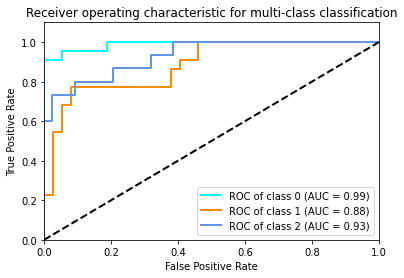

In [13]:
def calc_plot_roc(X_test, y_test, y_pred, classes):
    n_classes = len(classes)
    
    fpr, tpr, auc = dict(), dict(), dict()
    for i in range(n_classes):
        y_test_cl = y_test[:,i]
        y_score_cl = y_pred[:,i]
        fpr[i], tpr[i], _ = roc_curve(y_test_cl, y_score_cl)
        auc[i] = roc_auc_score(y_test_cl, y_score_cl)
        
    lw = 2
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC of class {0} (AUC = {1:0.2f})'.format(i, auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class classification')
    plt.legend(loc="lower right")
    plt.show()

calc_plot_roc(X_test, y_test, y_pred, classes=classes)